In [7]:
import pandas as pd
import numpy as np
from datetime import datetime,timedelta
from sklearn.metrics import mean_squared_error
from scipy.optimize import curve_fit
from scipy.optimize import fsolve
import matplotlib.pyplot as plt
%matplotlib inline

In [8]:
df=pd.read_csv("Indonesia.csv")

In [9]:
df

,Date,Case
0,62,2
1,63,2
2,64,2
3,65,2
4,66,4
5,67,4
6,68,6
7,69,19
8,70,27
9,71,34


In [26]:
#@title { vertical-output: true, display-mode: "form" }
import numpy as np
from scipy.optimize import curve_fit, fsolve
from IPython.display import HTML as html_print


def logistic_model(x, a, b, c):
    return c / (1 + np.exp(-(x - b) / a))


# fit the data to the model (find the model variables that best approximate)
def predict_logistic_maximum(df):
    samples = df.shape[0]
    x_days = df['Date'].tolist()
    y_cases = df['Case'].tolist()
    initial_guess = 4, 100, 25000 # speed, peak, amplitude

    fit = curve_fit(logistic_model, x_days, y_cases, p0=initial_guess, maxfev=9999)

    # parse the result of the fit
    speed, x_peak, y_max = fit[0]
    speed_error, x_peak_error, y_max_error = [np.sqrt(fit[1][i][i]) for i in [0, 1, 2]]

    # find the "end date", as the x (day of year) where the function reaches 99.99%
    end = int(fsolve(lambda x: logistic_model(x, speed, x_peak, y_max) - y_max * 0.9999, x_peak))

    return x_days, y_cases, speed, x_peak, y_max, x_peak_error, y_max_error, end, samples


# print results
def print_prediction_without_error(df, label):
    x, y, speed, x_peak, y_max, x_peak_error, y_max_error, end, samples = predict_logistic_maximum(df)
    print( "Prediksi "+label  +
          " Kasus Max " + str(int(round(y_max))) +
          ", Puncak pada hari " + str(int(round(x_peak))) +" Kalender Berjalan" +
          ", berakhir pada tanggal " + str(end)+".")
    return y_max

# print results
def print_prediction(df, label):
    x, y, speed, x_peak, y_max, x_peak_error, y_max_error, end, samples = predict_logistic_maximum(df)
    print( "Prediksi "+label  +
          " Kasus Max " + str(int(round(y_max))) +
          " (± " + str(int(round(y_max_error))) + ")" +
          ", Puncak pada hari " + str(int(round(x_peak))) +" Kalender Berjalan" +
          " (± " + str(round(x_peak_error, 2)) + ")" +
          ", berakhir pada tanggal " + str(end)+".")
    return y_max


print_prediction(df[:-2], "2 hari lalu")
print_prediction(df[:-1], "Kemarin")
pred = print_prediction(df, "hari ini")
print()
html_print("Total kasus akan stabil pada, per hari ini " + str(int(round(pred)))+ " Kasus"+ "</b>")


Prediksi 2 hari lalu Kasus Max 3878 (± 8626), Puncak pada hari 88 Kalender Berjalan (± 9.63), berakhir pada tanggal 121.
Prediksi Kemarin Kasus Max 1548 (± 742), Puncak pada hari 84 Kalender Berjalan (± 2.43), berakhir pada tanggal 116.
Prediksi hari ini Kasus Max 1326 (± 313), Puncak pada hari 83 Kalender Berjalan (± 1.3), berakhir pada tanggal 114.



In [37]:
#@title { vertical-output: true, display-mode: "form" }
import matplotlib.pyplot as plt
plt.rc('font', size=14)


def add_real_data(df, label, color=None):
    x = df['Date'].tolist()
    y = df['Case'].tolist()
    plt.scatter(x, y, label="Data (" + label + ")", c=color)


def add_logistic_curve(df, label, **kwargs):
    x, _, speed, x_peak, y_max, _, _, end, _ = predict_logistic_maximum(df)
    x_range = list(range(min(x), end))
    plt.plot(x_range,
             [logistic_model(i, speed, x_peak, y_max) for i in x_range],
             label="Logistic model (" + label + "): " + str(int(round(y_max))),
             **kwargs)
    return y_max

def add_logistic_curve_with_error(df, label, **kwargs):
    x, y, speed, x_peak, y_max, x_peak_error, y_max_error, end, samples = predict_logistic_maximum(df)
    x_range = list(range(min(x), end))
    plt.plot(x_range,
            [logistic_model(i, speed, x_peak+x_peak_error, y_max+y_max_error) for i in x_range],
            label="Logistic model (" + label + "): " + str(int(round(y_max))),
            **kwargs)
    plt.plot(x_range,
        [logistic_model(i, speed, x_peak-x_peak_error, y_max-y_max_error) for i in x_range],
        label="Logistic model (" + label + "): " + str(int(round(y_max))),
        **kwargs)
    return y_max



def label_and_show_plot(plt, title, y_max=None):
    plt.title(title)
    plt.xlabel("Hari sejak 1 Januari 2020")
    plt.ylabel("Jumlah Kasus")
    if (y_max):
        plt.ylim(0, y_max*1.2 )
    plt.legend()
    plt.show()




Prediksi hari ini Kasus Max 1326, Puncak pada hari 83 Kalender Berjalan, berakhir pada tanggal 114.


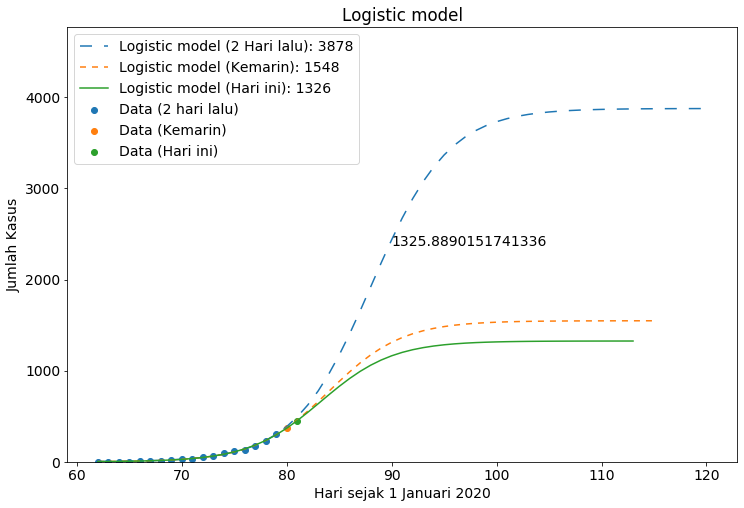

In [38]:
# Plot

plt.figure(figsize=(12, 8))
plt.figtext(0.5, 0.5, print_prediction_without_error(df, "hari ini") )
add_real_data(df[:-2], "2 hari lalu")
add_real_data(df[-2:-1], "Kemarin")
add_real_data(df[-1:], "Hari ini")
add_logistic_curve(df[:-2], "2 Hari lalu", dashes=[8, 8])
add_logistic_curve(df[:-1], "Kemarin", dashes=[4, 4])
y_max = add_logistic_curve(df, "Hari ini")
label_and_show_plot(plt, "Logistic model", y_max*3)
plt.show()

Prediksi hari ini Kasus Max 1326 (± 313), Puncak pada hari 83 Kalender Berjalan (± 1.3), berakhir pada tanggal 114.


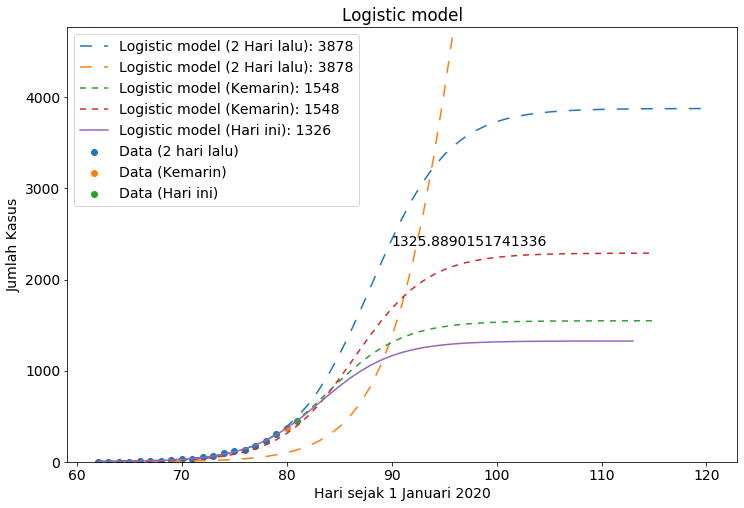

In [34]:
# Plot

plt.figure(figsize=(12, 8))
plt.figtext(0.5, 0.5, print_prediction(df, "hari ini") )
add_real_data(df[:-2], "2 hari lalu")
add_real_data(df[-2:-1], "Kemarin")
add_real_data(df[-1:], "Hari ini")
add_logistic_curve_with_error(df[:-2], "2 Hari lalu", dashes=[8, 8])
add_logistic_curve_with_error(df[:-1], "Kemarin", dashes=[4, 4])
y_max = add_logistic_curve(df, "Hari ini")
label_and_show_plot(plt, "Logistic model", y_max*3)
plt.show()

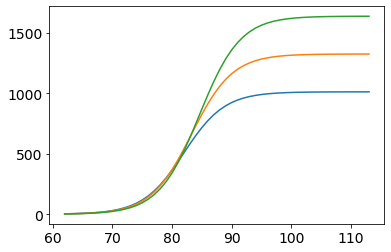

In [54]:
x, y, speed, x_peak, y_max, x_peak_error, y_max_error, end, samples = predict_logistic_maximum(df)
x_range = list(range(min(x), end))
plt.plot(x_range,[logistic_model(i, speed, x_peak-x_peak_error, y_max-y_max_error) for i in x_range])
plt.plot(x_range,[logistic_model(i, speed, x_peak, y_max) for i in x_range])
plt.plot(x_range,[logistic_model(i, speed, x_peak+x_peak_error, y_max+y_max_error) for i in x_range])

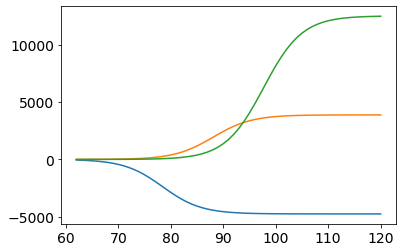

In [58]:
x, y, speed, x_peak, y_max, x_peak_error, y_max_error, end, samples = predict_logistic_maximum(df[:-2])
x_range = list(range(min(x), end))
plt.plot(x_range,[logistic_model(i, speed, x_peak-x_peak_error, y_max-y_max_error) for i in x_range])
plt.plot(x_range,[logistic_model(i, speed, x_peak, y_max) for i in x_range])
plt.plot(x_range,[logistic_model(i, speed, x_peak+x_peak_error, y_max+y_max_error) for i in x_range])

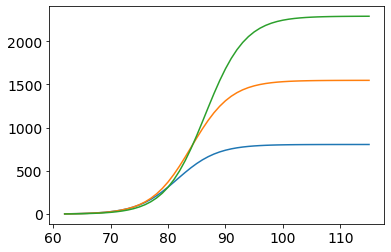

In [52]:
x, y, speed, x_peak, y_max, x_peak_error, y_max_error, end, samples = predict_logistic_maximum(df[:-1])
x_range = list(range(min(x), end))
plt.plot(x_range,[logistic_model(i, speed, x_peak-x_peak_error, y_max-y_max_error) for i in x_range])
plt.plot(x_range,[logistic_model(i, speed, x_peak, y_max) for i in x_range])
plt.plot(x_range,[logistic_model(i, speed, x_peak+x_peak_error, y_max+y_max_error) for i in x_range])

In [43]:
y_max

1325.8890151741336

In [44]:
y_max_error

313.07170412780073